In [117]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import networkx as nx
import os, sys
from itertools import product
from matplotlib.animation import FuncAnimation
import math
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner
from mesa.batchrunner import FixedBatchRunner
from IPython.display import clear_output
from itertools import combinations
from matplotlib.gridspec import SubplotSpec
#plt.style.use('seaborn-pastel')
#from tqdm.autonotebook import tqdm

In [69]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,6)})

#global function that calculates the weight of the edge, args: the 2 nodes (agent class objects)
def Edge_Weight(node1,node2, b, a):
        try:
             weight = 1+math.exp(a*((node1.m-node2.m)-b))
        except OverflowError:
             weight = float('inf')
        return 1/weight                

In [3]:
class MoneyAgent(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.m = self.model.T
        self.lamda = round(random.uniform(0.1,1),1)
        while (self.lamda == 1):
            self.lamda = round(random.uniform(0.1,1),1)
        self.model.agents.append(self)
        
    def neighbors(self):
        neighbors_nodes = list(nx.all_neighbors(self.model.G,self.unique_id))
        neighbors = []
        for node in neighbors_nodes:
            for agent in self.model.agents:
                if(agent.unique_id == node):
                    neighbors.append(agent)
        return neighbors
            
    def give_money(self):
        b = self.model.b
        a = self.model.a
        neighbors = self.neighbors()
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            while(other.unique_id == self.unique_id):
                other = self.random.choice(neighbors)  
            w = self.model.G[self.unique_id][other.unique_id]['weight'] 
            #print(w)
            if(w >= random.random()): 
                xi = self.m
                xj = other.m
                delta_m = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_m
                xj_new = xj + delta_m
                other.m = xj_new
                self.m = xi_new
                for neighbor in neighbors:
                    self.model.G[self.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(self,neighbor,b, a)
                other_neighbors = other.neighbors()
                for neighbor in other_neighbors:
                    if(neighbor.unique_id != other.unique_id):
                        #print("Other: {}  Neighbor: {}".format(other.unique_id,neighbor.unique_id))
                        self.model.G[other.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(other,neighbor,b, a)
                
    def Local_Attachment(self):
        b =  self.model.b
        a = self.model.a
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.model.nodes)
            node1 = random.choice(self.model.nodes)
        for agent in self.model.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.model.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, b, a))
        
    
    def Link_Deletion(self):
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==False):
            node1 = random.choice(self.model.nodes)
            node2 = random.choice(self.model.nodes)
        self.model.G.remove_edge(node1,node2)
        
                 
    def step(self):
        if self.m > 0:
            self.give_money()
        self.Local_Attachment()
        self.Link_Deletion()

In [127]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,b =35.98, a = 0.6933,T=100,N=100): #N- number of agents
        self.N = N
        self.T = T
        self.b =b
        self.a = a
        self.agents = []
        self.gini = 0
        self.G = nx.barabasi_albert_graph(n=N, m = 1)
        nx.set_edge_attributes(self.G, 1, 'weight') #setting all initial edges with a weight of 1
        #print(nx.get_edge_attributes(self.G,'weight'))
        #nx.draw(self.G)
        self.nodes = np.linspace(0,N-1,N, dtype = 'int') #to keep track of the N nodes   
        self.layout = nx.spring_layout(self.G)
        
        self.schedule = RandomActivation(self)
        #self.datacollector = DataCollector(model_reporters = {"Gini": 'gini', 'beta': 'b', 'a': 'a'})
                                                                   #agent_reporters={"mi":'m','lamda':'lamda' }
        
        for i, node in enumerate(self.G.nodes()):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)
           
        self.running = True
        #self.datacollector.collect(self)
        
    def Global_Attachment(self):
        #print("Global Attachment no: {}".format(self.count))
        node1 = random.choice(self.nodes)
        node2 = random.choice(self.nodes)
        while(self.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.nodes)
            node1 = random.choice(self.nodes)
        #adding the edge node1-node2
        for agent in self.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, self.b, self.a)) 
        
        
    def compute_gini(self):
        agent_wealths = [agent.m for agent in self.schedule.agents]
        x = sorted(agent_wealths)
        #print(len(x))
        B = sum(xi * (self.N - i) for i, xi in enumerate(x)) / (self.N * sum(x))
        return 1 + (1 / self.N) - 2 * B

    def step(self):
        self.schedule.step()
        # collect data
        self.Global_Attachment() #for sensitivity analysis
        self.gini = self.compute_gini()
        #self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.step()
            #self.Global_Attachment()
            #self.gini = self.compute_gini()
            
            #here, find mean and variance and save it as model parameters

In [37]:
N = 100
T = 100
steps = 10
b = 35.98
a = 0.6933
agents = []
model = BoltzmannWealthModelNetwork(b, a,T,N)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
model_df = model_df.drop(labels = 0, axis = 0)
#model.model_reporters.items()
#agent_df = model.datacollector.get_agent_vars_dataframe()
#agent_df.reset_index(level=1, inplace = True)
#agent_df['mt'] = agent_df.mi/T
#del agents
#print(model.collect_model_vars(model))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


AttributeError: 'BoltzmannWealthModelNetwork' object has no attribute 'datacollector'

A higher Gini index indicates greater inequality, with high-income individuals receiving much larger percentages of the total income of the population.

In [28]:
model_df

,Gini,beta,a
1,0.142103,35.98,0.6933
2,0.189647,35.98,0.6933
3,0.251534,35.98,0.6933
4,0.271861,35.98,0.6933
5,0.276903,35.98,0.6933
6,0.302638,35.98,0.6933
7,0.331246,35.98,0.6933
8,0.340265,35.98,0.6933
9,0.332599,35.98,0.6933
10,0.357965,35.98,0.6933


# Sensitivity Analysis

# SOBOL

In [130]:
problem = {
    'num_vars': 2,
    'names': ['b', 'a'],
    'bounds': [[0, 50], [0, 1]]
}

fixed_parameters = {'N' : 500,'T' : 100}
model_reporters = {'Gini':lambda m:BoltzmannWealthModelNetwork.compute_gini(m), 'Homophily Parameter(a)': lambda m:m.a, 'Characteristic Dist(b)': lambda m:m.b}
#
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 20
max_steps = 100
distinct_samples = 10

# generating samples
param_values = saltelli.sample(problem, distinct_samples)
variable_parameters={name:[] for name in problem['names']}
print(len(param_values))
#print(param_values)

60


In [131]:
batch = BatchRunner(BoltzmannWealthModelNetwork,variable_parameters = variable_parameters,
                    fixed_parameters = fixed_parameters,max_steps=max_steps,iterations=2,model_reporters = model_reporters,
                    display_progress = True)
count = 0
for i in range(replicates):
    for vals in param_values: 
        vals = list(vals)
        #print(vals)

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output(wait=True)
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
data = batch.get_model_vars_dataframe()

100.00% done


In [132]:
data

,Run,Characteristic Dist(b),Gini,Homophily Parameter(a),N,T
610,0.927734,0.927734,0.324213,0.596680,500,100
70,0.927734,0.927734,0.341681,0.596680,500,100
1090,0.927734,0.927734,0.283391,0.596680,500,100
611,0.927734,0.927734,0.308992,0.176758,500,100
67,0.927734,0.927734,0.282269,0.596680,500,100
...,...,...,...,...,...,...
432,48.486328,48.486328,0.336225,0.346680,500,100
74,48.486328,48.486328,0.334262,0.926758,500,100
75,48.486328,48.486328,0.329001,0.926758,500,100
1034,48.486328,48.486328,0.371408,0.926758,500,100


In [133]:
data = data.drop(columns = 'Run')
data = data.sort_index(axis = 0)
data

,Characteristic Dist(b),Gini,Homophily Parameter(a),N,T
0,10.986328,0.323466,0.096680,500,100
1,25.927734,0.323466,0.096680,500,100
2,10.986328,0.339370,0.676758,500,100
3,10.986328,0.310825,0.676758,500,100
4,25.927734,0.351851,0.096680,500,100
...,...,...,...,...,...
1195,27.490234,0.364802,0.690430,500,100
1196,28.173828,0.350645,0.958008,500,100
1197,28.173828,0.363770,0.958008,500,100
1198,27.490234,0.366901,0.690430,500,100


In [134]:
file = "SensitivityAnalysis\Data_AlbertBarabasi\Run2"
os.makedirs(file)

In [135]:
data.to_csv(file + "\data.csv") 

In [136]:
data.loc[data['Gini'] == min(data.Gini)]

,Characteristic Dist(b),Gini,Homophily Parameter(a),N,T
589,2.490234,0.265721,0.19043,500,100


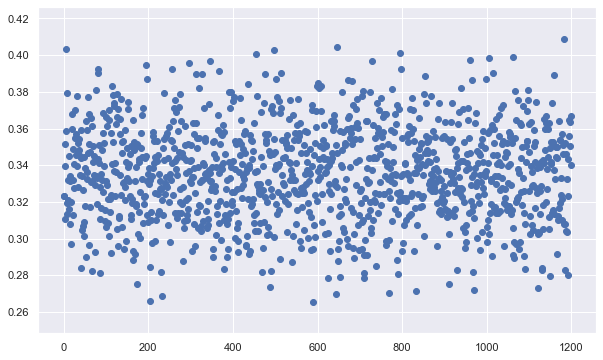

In [137]:
plt.scatter(data.index, data.Gini)

(array([ 15.,  52., 110., 190., 259., 246., 192.,  92.,  31.,  13.]),
 array([0.26572089, 0.28003707, 0.29435325, 0.30866944, 0.32298562,
        0.3373018 , 0.35161798, 0.36593417, 0.38025035, 0.39456653,
        0.40888272]),
 <a list of 10 Patch objects>)

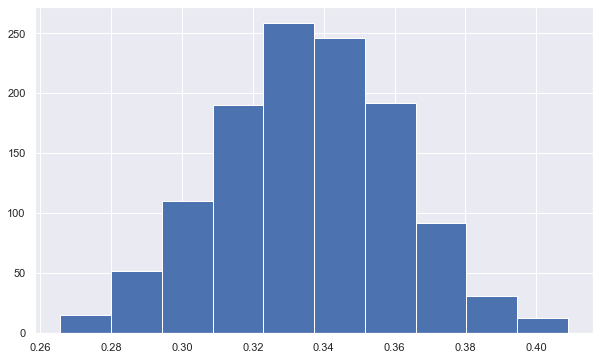

In [138]:
plt.hist(data.Gini)

In [139]:
Si_gini = sobol.analyze(problem, data['Gini'].to_numpy(), print_to_console=True)

Parameter S1 S1_conf ST ST_conf
b 0.289034 0.207663 1.141758 0.202140
a 0.034639 0.175984 0.771443 0.145040

Parameter_1 Parameter_2 S2 S2_conf
b a -0.138665 0.277955


In [140]:
def plot_index(s, params, i,ax, title=''):
   
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        #plt.figure()

    l = len(indices)
    #print(params)
    #print(range(l))

    ax.set_title(title)
    ax.set_ylim([-0.2, len(indices) - 1 + 0.2])
    ax.set_yticks(range(l))
    ax.set_yticklabels(params)
    ax.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o', color = 'red')
    ax.axvline(0, c='navy')

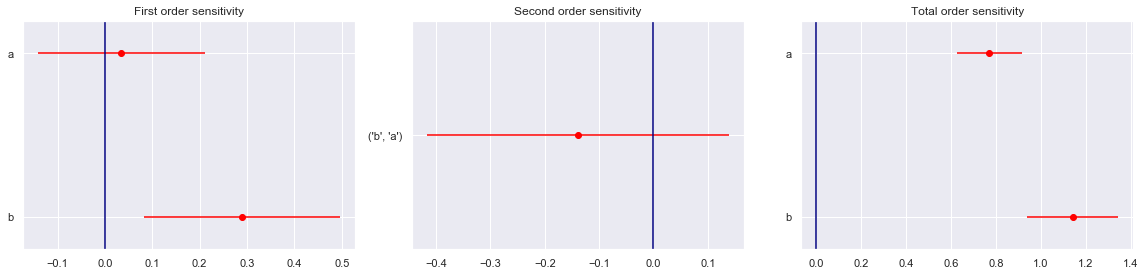

In [141]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,3,figsize = (16,4)) 

k = 0 

# First order
plot_index(Si_gini, problem['names'], '1',ax[k], 'First order sensitivity')
k +=1

# Second order
plot_index(Si_gini, problem['names'], '2',ax[k], 'Second order sensitivity')
k +=1

# Total order
plot_index(Si_gini, problem['names'], 'T',ax[k], 'Total order sensitivity')

plt.tight_layout()
plt.savefig(file +"\sobol_sensitivity2")